# Predicting USA GDP with LSTM

<h3> Task </h3> <p>Predicting USA GDP by using data from 1947 to date.</p>

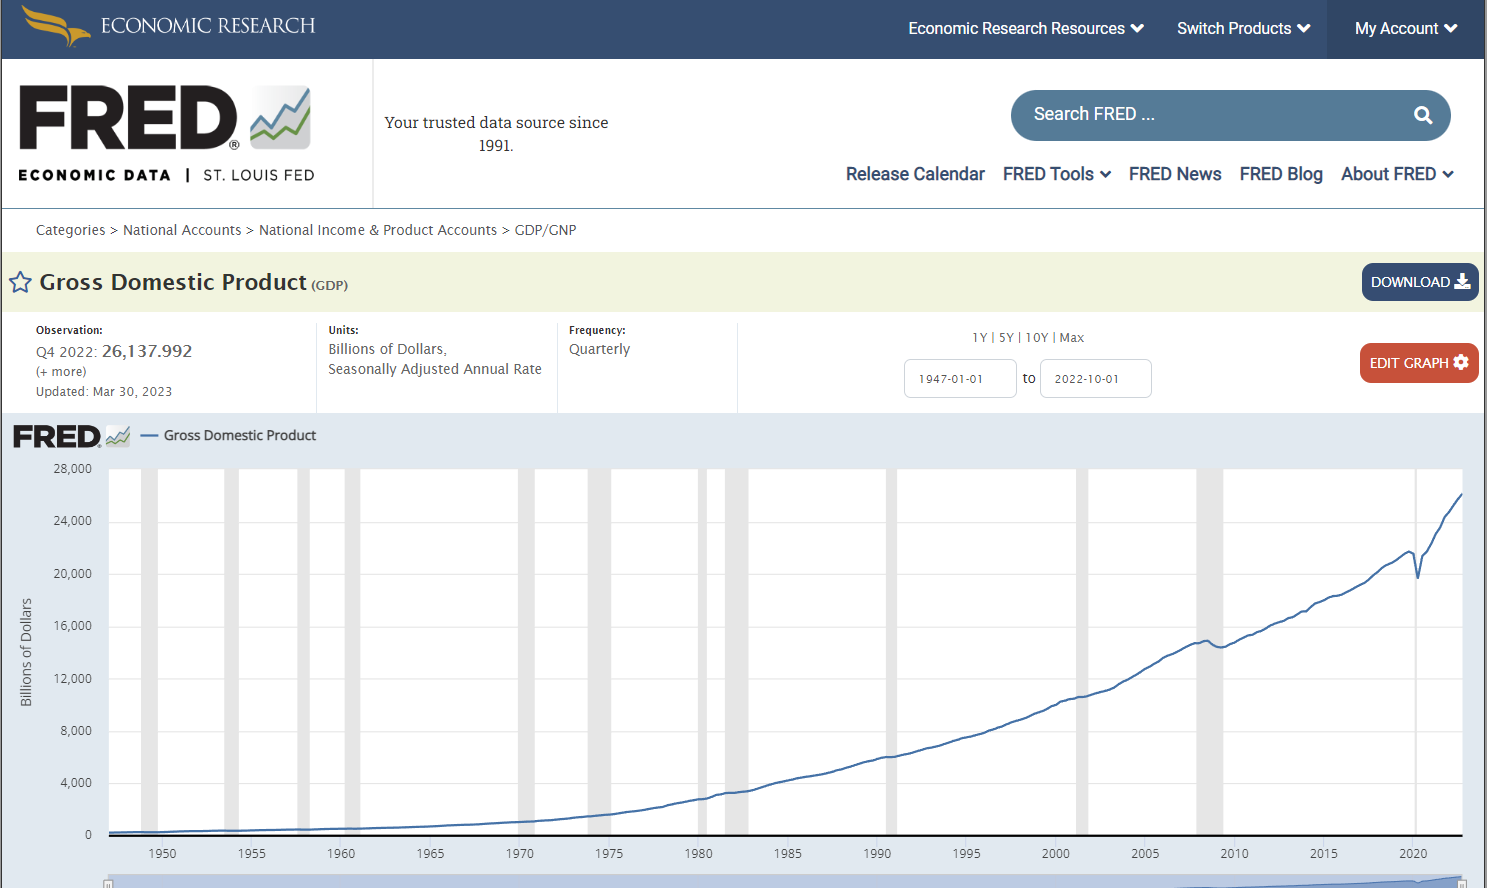

**source:** <a href="https://fred.stlouisfed.org/series/GDP">USA Gross Domestic Product (GDP)</a>

**Import libraries:**

In [1]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

**Extra library for interactive visualisation plotly and cufflinks:**

In [2]:
# import libraries
import plotly.express as px
import cufflinks as cf

# Ploty can host your visualization online and offline
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

# notebook to work 
init_notebook_mode(connected = True)

# to use cufflinks offline
cf.go_offline()

In [3]:
# import data
df_parse_date = pd.read_csv('USAGDP.csv', index_col='DATE',parse_dates=True) # set date to index for analysis purpose
df = pd.read_csv('USAGDP.csv') # for visualization purpose
# set freq to 'MS'
# df_parse_date.index.freq = 'MS'

### **Basic EDA and wrangling:**

In [4]:
# read first 10 rows
df.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [5]:
# shape of the data
df_parse_date.shape

(304, 1)

In [6]:
# check for null values and sum
df_parse_date.isnull().sum()

GDP    0
dtype: int64

In [7]:
# data type
df_parse_date.dtypes

GDP    float64
dtype: object

Visualize the data:

In [8]:
# plot the dataframe 
import plotly.express as px

df = df.copy()
fig = px.line(df, x="DATE", y='GDP', title='Gross Domestic Product (GDP) [Billions of Dollars]')
fig.show()

### **Decompose the GDP series:**   for seasonality and trends

In [9]:
# import statsmodels for decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
# assign the variable
results = seasonal_decompose(df_parse_date['GDP'])

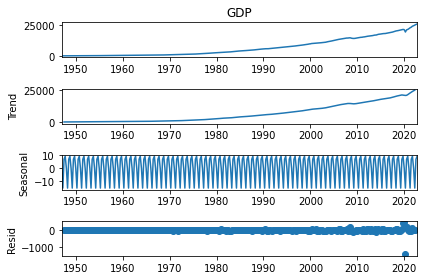

In [11]:
# output the result
results.plot();

You can also plot each and every item in the result:

In [12]:
# results.seasonal.plot(figsize=(12,8), title = "Seasonal");
# results.resid.plot(figsize=(12,8), title = "Resid");
# results.trend.plot(figsize=(12,8), title = "Trend");

### **Train - test - split:**

In [13]:
# data shape
print('Length:', len(df_parse_date))
# assign 12 to the test data
print('Train size:', len(df_parse_date)-12)
print('Test size: 12')

Length: 304
Train size: 292
Test size: 12


In [14]:
# assign
train = df_parse_date.iloc[:len(df)-12]
test = df_parse_date.iloc[len(df)-12:]

In [15]:
# check the test data
test.shape

(12, 1)

###  **Preprocess the data:**

In [16]:
# preprocess the data since most algorithms finds it hard to deal with skewed dataset
from sklearn.preprocessing import MinMaxScaler

<h4> x<sub>scaled</sub> = (x - x<sub>min</sub>)/ (x<sub>max</sub> - x<sub>min</sub>  </h4>

In [17]:
# instatiate MinMaxScaler
scaler = MinMaxScaler()

In [18]:
# fit the data trainset
scaler.fit(train) # finds the max value in the train data it'll convert intergers to float 

MinMaxScaler()

In [19]:
# TRANSFORM the dataset
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### **Manipulate the transformed data to feed into batches for neural networks:**

[t1, t2, t3] ------> [t4] : timestamp one to three and predict four.

In [20]:
# import timeseriesGenerator for creating batches
from keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
# set the parameters for the Generator
n_input = 50
# number of features 
n_features = 1 

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input, batch_size=2)

### **Model creation:**

Import libraries for creating the RNN

In [22]:
# import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Instatiate the model:

In [23]:
# instatiate the sequence object
model = Sequential()

Add layers and parameters of the network:

In [24]:
# add an LSTM layers and some neurons
model.add(LSTM(150, activation='relu',input_shape=(n_input,n_features)))

Aggregate the neurons to output only a final:

In [25]:
# aggregate to one final output
model.add(Dense(1))

Compile the model:

In [26]:
# compile the model
model.compile(optimizer='adam',loss='mse')

model summary (architecture):

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**fit the model:**

In [28]:
# fit the RNN model and epochs/iteration
model.fit(train_generator,epochs=25)

Epoch 1/25
121/121 [==============================] - 7s 45ms/step - loss: 0.0077
Epoch 2/25
121/121 [==============================] - 6s 53ms/step - loss: 0.0013
Epoch 3/25
121/121 [==============================] - 7s 57ms/step - loss: 2.9676e-04
Epoch 4/25
121/121 [==============================] - 8s 64ms/step - loss: 2.9371e-04
Epoch 5/25
121/121 [==============================] - 6s 47ms/step - loss: 5.7059e-04
Epoch 6/25
121/121 [==============================] - 5s 38ms/step - loss: 2.5866e-04
Epoch 7/25
121/121 [==============================] - 5s 42ms/step - loss: 4.6697e-04
Epoch 8/25
121/121 [==============================] - 5s 44ms/step - loss: 2.4619e-04
Epoch 9/25
121/121 [==============================] - 7s 56ms/step - loss: 3.7727e-04
Epoch 10/25
121/121 [==============================] - 7s 55ms/step - loss: 9.3816e-05
Epoch 11/25
121/121 [==============================] - 7s 58ms/step - loss: 4.4781e-04
Epoch 12/25
121/121 [==============================] - 6s 52

**Plot the loss:**

In [29]:
# get model keys
modelLoss = model.history.history['loss']

In [30]:
# create a dataframe
df_modelLoss = pd.DataFrame({'loss':modelLoss})
# insert a value x for creating interactive plot using plotly express
df_modelLoss.insert(0, 'range', list(range(len(df_modelLoss))))
# interactive plotly express
fig = px.line(df_modelLoss, x="range", y='loss', title='Model loss')
fig.show()

# **Forecast using the model:**

In this section we will forecast using the model we've have created.

In [31]:
# holding predictions
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants (same format as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1,n_input,n_features))

# how far into the future will I forecast?
# len(test) ---> 24
for i in range(len(test)):
    # one timestamp ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    #  store that prediction
    test_predictions.append(current_pred) 
    # UPDATE current batch to include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [32]:
# reversing the values back to get the original predicted values
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions.shape

(12, 1)

In [33]:
# add the predictions to the test dataset
test['Predictions'] = true_predictions
# output test data set with prediction column
test

,GDP,Predictions
DATE,,
2020-01-01,21538.032,21906.553123
2020-04-01,19636.731,22130.699595
2020-07-01,21362.428,22355.163338
2020-10-01,21704.706,22580.174628
2021-01-01,22313.850,22806.086557
2021-04-01,23046.934,23033.193368
2021-07-01,23550.420,23261.697192
2021-10-01,24349.121,23491.766899
2022-01-01,24740.480,23723.515069


In [34]:
# interactive plotly
test.iplot(kind="line", title='GDP and Predicitions')

### **Save the model:**


Now save your model to a file for more <a href="https://www.tensorflow.org/guide/keras/save_and_serialize">Save and load Keras models</a>

In [35]:
# save the model
model.save('USAgDp.h5')
# load the model
from keras.models import load_model
new_model= load_model('USAgDp.h5')